# Generative Painting Style Using Generative Adversarial Networks (GANs)

This project aims to build a Deep Convolutional Generative Adversarial Network (DCGAN) that trains on images of Monet paintings to capture their qualities and then generate Monet-esque images. Several techniques will be showcased such as image augmentation for training diversification, an iterative approach to DCGAN architecture resulting in multiple model runs and submissions, and a discussion on common issues that can arise during GAN training.

***Note:*** *This notebook was only used for general model setup and troubleshooting on local hardware and has since been deprecated. The final version of this notebook/project is `Adversarial_Painting_Kaggle.ipynb` where the final run and submission can be found using Kaggle's P100 GPU for use on 256x256 images.*

---

This project derives from the Kaggle competition with the name Gan Getting Started (I'm Something of a Painter Myself), found here: https://www.kaggle.com/competitions/gan-getting-started/overview

You can find this project at the github repo: https://github.com/chill0121/Kaggle_Projects/tree/main/Adversarial_Painting

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
  - 1.1. [Dataset Information](#data)
  - 1.2. [Kaggle Information](#kaggle)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)
  - 3.1. [First Looks](#firstlook)
  - 3.2. [Image Augmentation](#aug)
- 4.[**Exploratory Data Analysis (EDA)**](#eda)
- 5.[**Models**](#models)
  - 5.1. [Generative Adversarial Network (GAN)](#gan)
- 6.[**Results**](#results)
- 7.[**Conclusion - Kaggle Submission Test Set**](#conclusion)
  - 7.1. [Possible Areas for Improvement](#improvements)

- [**Appendix A - Online References**](#appendixa)

## 1. Data Source Information <a name="datasource"></a>

---


### 1.1. Data Information: <a name="data"></a>

Color images (256 x 256 pixels) extracted from histopathologic scans of lymph node sections. These 96 x 96 images are patches of a whole slide image.

- The monet directories contain Monet paintings used to train the model.
- The photo directories contain photos used to add the Monet-style to them for submission.

**Data Info:**
- 300 Monet Painting Images
    - 256 x 256 x 3
- 7028 Photos
    - 256 x 256 x 3

### 1.2. Kaggle Information: <a name="kaggle"></a>

#### Description:

We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this getting started competition, you will bring that style to your photos or recreate the style from scratch!

Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Monet? That’s the challenge you’ll take on!

The Challenge:
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

Note: Monet-style art can be created from scratch using other GAN architectures like DCGAN. The submitted image files do not necessarily have to be transformed photos.

#### Evaluation:

MiFID
Submissions are evaluated on MiFID (Memorization-informed Fréchet Inception Distance), which is a modification from Fréchet Inception Distance (FID).

The smaller MiFID is, the better your generated images are.

What is FID?
Originally published here ([github](https://arxiv.org/abs/1706.08500)), FID, along with Inception Score (IS), are both commonly used in recent publications as the standard for evaluation methods of GANs.

#### Citation: 

Amy Jang, Ana Sofia Uzsoy, Phil Culliton. (2020). I’m Something of a Painter Myself. Kaggle. https://kaggle.com/competitions/gan-getting-started

###### [Back to Table of Contents](#toc)

## 2. Setup <a name="setup"></a>

---

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
import torch

###### [Back to Table of Contents](#toc)

### 2.1. Environment Information for Reproducibility: <a name="env"></a>

In [387]:
print(f"Python version: {sys.version}")

packages = [pd, np, sns, tf, torch]
for package in packages:
    print(f"{str(package).partition('from')[0]} using version: {package.__version__}")

Python version: 3.11.9 (main, Apr  2 2024, 08:25:04) [Clang 15.0.0 (clang-1500.3.9.4)]
<module 'pandas'  using version: 2.1.4
<module 'numpy'  using version: 1.26.4
<module 'seaborn'  using version: 0.13.2
<module 'tensorflow'  using version: 2.16.2
<module 'torch'  using version: 2.2.2


###### [Back to Table of Contents](#toc)

### 2.2. Importing the Data: <a name="dataimport"></a>

In [388]:
# Set directories
current_wdir = os.getcwd()
data_folder = current_wdir + '/Data/'

In [389]:
img_size = 64
batch_size = 16
rand_seed = 11

monet = tf.keras.utils.image_dataset_from_directory(f"{data_folder}/monet_jpg", 
                                                      label_mode = None, 
                                                      image_size = (img_size, img_size), 
                                                      batch_size = batch_size)
# monet = monet.map(lambda x: x / 255.0)
monet = monet.map(lambda x: (x / 127.5) - 1)

Found 300 files.


As expected we're showing 300 images of Monet paintings.

###### [Back to Table of Contents](#toc)

## 3. Data Preprocessing <a name="datapre"></a>

---

### 3.1. First Looks: <a name="firstlook"></a>

To get an idea what the paintings looks like, we should plot a few here.

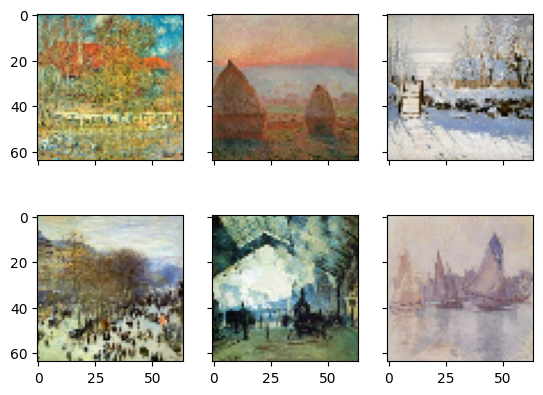

In [390]:
for img in monet:
    fig, ax = plt.subplots(2, 3, sharex = True, sharey = True)
    img = ((img.numpy() + 1) * 127.5).astype(np.uint8)
    for i in range(6):
        ax[i // 3, i % 3].imshow(img[i])
    break

###### [Back to Table of Contents](#toc)

### 3.2. Image Augmentation: <a name="aug"></a>

Training a deep learning model off of 300 images isn't that many. 

Let's add some image augmentation/transformations to the dataloader, effectively increasing the size of the dataset size.

**Transformations:**
- Randomly flip the image.
    - Horizontal
    - Vertical
- Random Rotation
- Randomly Crop the Image (interpolates pixels to maintain original image size.)

In [391]:
# Transformation object.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomCrop(img_size, img_size)])

# Autotune to set buffer size.
AUTOTUNE = tf.data.AUTOTUNE

# Function to setup the transformations within the dataloader.
def prepare(ds, shuffle = False, augment = False):
  if shuffle:
    ds = ds.shuffle(1000)

  if augment:
    ds = ds.map(lambda x: (data_augmentation(x, training=True)), 
                num_parallel_calls = AUTOTUNE)

  # Prefetch buffer necessary here to ensure proper loading during training.
  return ds.prefetch(buffer_size = AUTOTUNE)

Now we can prepare the dataloader with the function we just created.

In [392]:
monet_transformed = prepare(monet, shuffle = True, augment = True)

Let's plot a few images and see the transformations in practice.

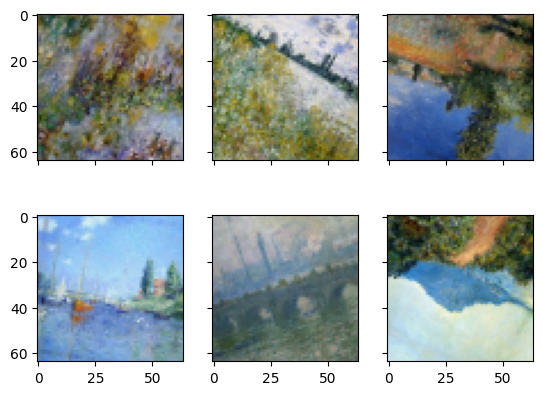

In [393]:
for img in monet_transformed:
    fig, ax = plt.subplots(2, 3, sharex = True, sharey = True)
    img = ((img.numpy() + 1) * 127.5).astype(np.uint8)
    for i in range(6):
        ax[i // 3, i % 3].imshow(img[i])
    break

Looks good, we can obviously see the rotations and a few flips even without seeing the originals.

###### [Back to Table of Contents](#toc)

## 4. Exploratory Data Analysis (EDA) <a name="eda"></a>

---

Let's load the images outside the dataloader so we can avoid the batching and do a little EDA. Since there are only 300, this isn't too much of a memory hit.

In [394]:
monet_files = os.listdir(f"{data_folder}/monet_jpg")
monet_array = np.zeros((len(monet_files), 256, 256, 3)) # 4D Array with shape (n_images, height, width, channels)
for i, file in enumerate(monet_files):
    img = Image.open(f"{data_folder}/monet_jpg/{file}")
    monet_array[i] = np.asarray(img)

Since a Generative Adversarial Network is going to be trained to generate images in Monet's style from scratch, it might be good to inform ourselves of what color intensities are present within this dataset.

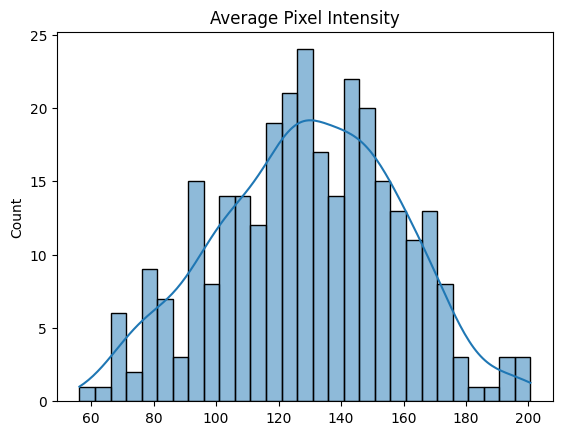

In [395]:
# Find the mean pixel intensity of each image (down to one value along all axes).
mean_intensity = monet_array.mean(axis = 1).mean(axis = 1).mean(axis = 1)

sns.histplot(mean_intensity, binwidth = 5, kde = True)
plt.title('Average Pixel Intensity')
plt.show()

Look at the mean pixel intensity value of each image here, we can see that there aren't many images skewing white (close to 255, right) or black (close to 0, left). Most images sit near the middle around 130 (127.5 would be center).

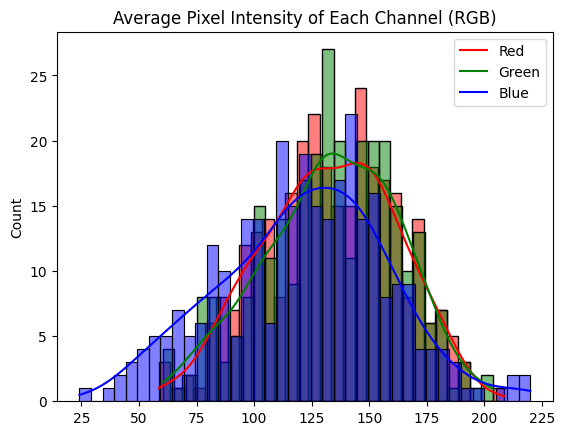

In [396]:
mean_intensity_rgb = monet_array.mean(axis = 1).mean(axis = 1)

# Plot the distribution of the mean intensities of individual RGB channels.
rgb_dict = {0:'Red', 1:'Green', 2:'Blue'}
for i in rgb_dict.keys():
    sns.histplot(mean_intensity_rgb[:,i], color = rgb_dict[i], binwidth = 5, kde = True)#, ax = ax[i])
plt.title('Average Pixel Intensity of Each Channel (RGB)')
plt.legend(list(rgb_dict.values()))
plt.show()

- There doesn't seem to be too much difference in the distribution besides maybe a skew of the blue channel.
- The green and red distributions are very similar.

It seems Monet painted with a wide variety of colors and this should be present in the final generations.

###### [Back to Table of Contents](#toc)

## 5. Models <a name="models"></a>

---

### 5.1. Deep Convolutional Generative Adversarial Network (DCGAN) <a name="gan"></a>

Instead of performing style-transfer like pix2pix or with a CycleGAN, I plan to train a DCGAN to generate Monet-like images and see how well it performs in this competition.

To review, a DCGAN is a variation of the more general GAN models that utilizes deep convolutional layers in both the discriminator and generator. This, of course, means this type of model is adept at image data. 

DCGANs are comprised of two models, the Discriminator whose purpose is to identify (discriminate) real images from fake ones, and the Generator whose role is to generate images that hopefully imitate real images well enough to fool the Discriminator. The two goals of these models are diametrically opposed to each other, meaning if one is succeeding, the other is failing. This can be seen in the loss of each model, but there is no perfect metric to know when the model has converged, overfit, or suffered mode collapse (more on this later). This fact makes tuning a GAN model fairly subjective and requires balancing the two models so that they converge into a working model which be a difficult and time-consuming process.

In [397]:
latent_dim = 512
epochs = 100
num_img_saved = 3

Now we can initialize the Discriminator (sometimes called the Critic depending on application).

Generally the role of the discriminator isn't unlike a CNN used in classification: downsample an image into a feature space and classify it.

It's very important to not only plan the architectures of the discriminator and generator (input shapes vs output shapes, filter size, number of filters, strides, etc), but also choose the proper activation functions, especially for the last layers.

Since we're using Binary Cross Entropy as the loss function, the last layer can either use a sigmoid activation function or ensure the loss function specifies `from_logits = True`.

In [398]:
discriminator = tf.keras.Sequential(
    [tf.keras.Input(shape = (img_size, img_size, 3)),
     tf.keras.layers.Conv2D(64, kernel_size = 5, strides = 2, padding = 'same', use_bias = False),
     #tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(negative_slope = 0.2),
     tf.keras.layers.Conv2D(128, kernel_size = 5, strides = 2, padding = 'same', use_bias = False),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(negative_slope = 0.2),
     tf.keras.layers.Conv2D(128, kernel_size = 5, strides = 2, padding = 'same', use_bias = False),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(negative_slope = 0.2),
     tf.keras.layers.Conv2D(256, kernel_size = 5, strides = 2, padding = 'same', use_bias = False),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(negative_slope = 0.2),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(1)],
     name = 'Discriminator')

discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_210 (Conv2D)             │ (None, 32, 32, 64)     │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_331 (LeakyReLU)     │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_211 (Conv2D)             │ (None, 16, 16, 128)    │       204,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_276         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_332 (LeakyReLU)     │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_212 (Conv2D)             │ (None, 8, 8, 128)      │       409,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_277         │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_333 (LeakyReLU)     │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_213 (Conv2D)             │ (None, 4, 4, 256)      │       819,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_278         │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_334 (LeakyReLU)     │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,444,545 (5.51 MB)

 Trainable params: 1,443,521 (5.51 MB)

 Non-trainable params: 1,024 (4.00 KB)

Now for the Generator.

This model requires us to architect a random latent vector as an input, then upsample this vector through an emergent feature space to the size of a real image which will then be input into the Discriminator during training. Several different model architectures can work here and many variations of GANs can be identified by the Generator's shape.

Here, we have a choice of activation function in the last layer which mostly depends on the range of pixel values of our images. In this case we normalized the images into the space of [-1, 1] so the hyperbolic tangent (tanh) activation function has been chosen. If we had normalized from [0, 1], the sigmoid function would be appropriate. Tanh seems to be accepted practice by performing the best in GANs, however.

In [399]:
# generator = tf.keras.Sequential(
#     [tf.keras.Input(shape = (latent_dim, )),
#      tf.keras.layers.Dense(4 * 4 * latent_dim),
#      tf.keras.layers.Reshape((4, 4, latent_dim)),
#      tf.keras.layers.Conv2DTranspose(256, kernel_size = 5, strides = 2, padding = 'same', use_bias = False),
#      #tf.keras.layers.BatchNormalization(),
#      tf.keras.layers.LeakyReLU(negative_slope = 0.2),
#      tf.keras.layers.Conv2DTranspose(256, kernel_size = 5, strides = 2, padding = 'same', use_bias = False),
#      tf.keras.layers.BatchNormalization(),
#      tf.keras.layers.LeakyReLU(negative_slope = 0.2),
#      tf.keras.layers.Conv2DTranspose(512, kernel_size = 5, strides = 2, padding = 'same', use_bias = False),
#      tf.keras.layers.BatchNormalization(),
#      tf.keras.layers.LeakyReLU(negative_slope = 0.2),
#      tf.keras.layers.Conv2DTranspose(512, kernel_size = 5, strides = 2, padding = 'same', use_bias = False),
#      tf.keras.layers.BatchNormalization(),
#      tf.keras.layers.LeakyReLU(negative_slope = 0.2),
#      tf.keras.layers.Conv2D(3, kernel_size = 7, padding = 'same', activation = 'tanh')],
#      name = 'Generator')
# generator.summary()

# generator = tf.keras.Sequential(
#     [tf.keras.Input(shape = (latent_dim, )),
#      tf.keras.layers.Dense(4 * 4 * latent_dim),
#      tf.keras.layers.Reshape((4, 4, latent_dim)),
#      tf.keras.layers.Conv2DTranspose(512, kernel_size = 5, strides = 2, padding = 'same', use_bias = False),
#      #tf.keras.layers.BatchNormalization(),
#      tf.keras.layers.LeakyReLU(negative_slope = 0.2),
#      tf.keras.layers.Conv2DTranspose(256, kernel_size = 5, strides = 2, padding = 'same', use_bias = False),
#      tf.keras.layers.BatchNormalization(),
#      tf.keras.layers.LeakyReLU(negative_slope = 0.2),
#      tf.keras.layers.Conv2DTranspose(128, kernel_size = 5, strides = 2, padding = 'same', use_bias = False),
#      tf.keras.layers.BatchNormalization(),
#      tf.keras.layers.LeakyReLU(negative_slope = 0.2),
#      tf.keras.layers.Conv2DTranspose(128, kernel_size = 5, strides = 2, padding = 'same', use_bias = False),
#      tf.keras.layers.BatchNormalization(),
#      tf.keras.layers.LeakyReLU(negative_slope = 0.2),
#      tf.keras.layers.Conv2D(3, kernel_size = 7, padding = 'same', activation = 'tanh')],
#      name = 'Generator')
# generator.summary()

generator = tf.keras.Sequential(
    [tf.keras.Input(shape = (latent_dim, )),
     tf.keras.layers.Dense(4 * 4 * latent_dim),
     tf.keras.layers.Reshape((4, 4, latent_dim)),
     tf.keras.layers.Conv2DTranspose(512, kernel_size = 5, strides = 2, padding = 'same', use_bias = False),
     #tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(negative_slope = 0.2),
     tf.keras.layers.Conv2DTranspose(256, kernel_size = 5, strides = 2, padding = 'same', use_bias = False),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(negative_slope = 0.2),
     tf.keras.layers.Conv2DTranspose(128, kernel_size = 5, strides = 2, padding = 'same', use_bias = False),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(negative_slope = 0.2),
     tf.keras.layers.Conv2DTranspose(64, kernel_size = 5, strides = 2, padding = 'same', use_bias = False),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(negative_slope = 0.2),
     tf.keras.layers.Conv2D(32, kernel_size = 5, padding = 'same', use_bias = False),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(negative_slope = 0.2),
     tf.keras.layers.Conv2D(3, kernel_size = 7, padding = 'same', activation = 'tanh')],
     name = 'Generator')
generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (None, 8192)           │     4,202,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_40 (Reshape)            │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_161            │ (None, 8, 8, 512)      │     6,553,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_335 (LeakyReLU)     │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_162            │ (None, 16, 16, 256)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_279         │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_336 (LeakyReLU)     │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_163            │ (None, 32, 32, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_280         │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_337 (LeakyReLU)     │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_164            │ (None, 64, 64, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_281         │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_338 (LeakyReLU)     │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_214 (Conv2D)             │ (None, 64, 64, 32)     │        51,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_282         │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_339 (LeakyReLU)     │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_215 (Conv2D)             │ (None, 64, 64, 3)      │         4,707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,114,723 (57.66 MB)

 Trainable params: 15,113,763 (57.65 MB)

 Non-trainable params: 960 (3.75 KB)

Now we need a way for these two models to be set up in an adversarial way. The following class will handle the training program.

In [400]:
# GAN Class was altered from https://keras.io/examples/generative/dcgan_overriding_train_step/
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        # self.seed_generator = tf.keras.random.SeedGenerator(rand_seed)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name = "D_Loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name = "G_Loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space.
        batch_size = tf.keras.ops.shape(real_images)[0]
        random_latent_vectors = tf.keras.random.normal(
            shape=(batch_size, self.latent_dim))#, seed=self.seed_generator)

        # Decode the latent space to a fake image.
        generated_images = self.generator(random_latent_vectors)

        # Zip with real images.
        combined_images = tf.keras.ops.concatenate([generated_images, real_images], axis=0)

        # # Assemble labels discriminating real from fake images.
        # labels = tf.keras.ops.concatenate([tf.keras.ops.ones((batch_size, 1)), tf.keras.ops.zeros((batch_size, 1))], axis=0)
        
        # # Add noise to labels.
        # labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Create labels for real (1) and fake (0) images
        real_labels = tf.ones((batch_size, 1))
        fake_labels = tf.zeros((batch_size, 1))

        # Apply label smoothing: change real labels from 1 to a value like 0.9
        smoothed_real_labels = real_labels * 0.9  # Real label smoothing
        combined_labels = tf.concat([smoothed_real_labels, fake_labels], axis=0)

        # Add some noise to the labels (optional but can help)
        combined_labels += 0.05 * tf.random.uniform(tf.shape(combined_labels))

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(combined_labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space.
        random_latent_vectors = tf.keras.random.normal(
            shape=(batch_size, self.latent_dim))#, seed=self.seed_generator)

        # Assemble misleading labels that show all real images.
        misleading_labels = tf.keras.ops.zeros((batch_size, 1))

        # Train the generator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update loss metrics.
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

Here we can create a callback for tensorflow to use at the end of each epoch. This class and function will save randomly generated images after each epoch -- This is incredibly important for the subjective tuning and analysis of how well the model performs as mode collapse or non-convergence can happen at any time during the training of a GAN.

In [401]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim
        # self.seed_generator = tf.keras.random.SeedGenerator(rand_seed)

    # Save a few generated images at each epoch.
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.keras.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors, training = False)
        generated_images = (generated_images + 1) * 127.5
        #generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.utils.array_to_img(generated_images[i])
            img.save(f"{current_wdir}/Generated_Images/{epoch+1:03}_{i}.jpg")
        
        # In the case of mode collapse for kaggle submissions.
        if epoch > (epochs - 21):
            n = 400
            random_latent_vectors = tf.keras.random.normal(shape=(n, self.latent_dim))
            generated_images = self.model.generator(random_latent_vectors, training = False)
            generated_images = (generated_images + 1) * 127.5
            #generated_images.numpy()
            for i in range(n):
                img = tf.keras.utils.array_to_img(generated_images[i])
                img.save(f"{current_wdir}/images/{epoch+1:03}_{i}.jpg")
            

In [402]:
gan = GAN(discriminator = discriminator, generator = generator, latent_dim = latent_dim)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.5, beta_2 = 0.9),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9),
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits = True))

history_gan = gan.fit(monet_transformed,
                      epochs = epochs,
                      callbacks = [GANMonitor(num_img = num_img_saved, latent_dim = latent_dim)])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 642ms/step - d_loss: 0.6716 - g_loss: 0.7116
Epoch 2/100
 4/19 ━━━━━━━━━━━━━━━━━━━━ 9s 620ms/step - d_loss: 0.6053 - g_loss: 1.4685 

KeyboardInterrupt: 

Methods Attempted to Mitigate Mode Collapse:

- Batch Normalization
- Layer Normalization
- Deeper Generator and Discriminator Networks
- Larger Latent Space (128 > 256 > 512)
- Different Filter Sizes in Generator
- One-Sided Label Smoothing for the Discriminator
- Remove All Seeds for Latent Vector Initialization
- Adjust Beta 1 and 2 on Optimizers for Generator and Discriminator
- Raise Learning Rate on Generator, leaving Discriminators at 0.0001.
- Flipped filters numbers to start at 512 and decrease.
- Larger Filters in Disc
- Use bias = false
- Unflip without bias

Too Try:

- Self-Modulation Layers instead of Batch Norm
- SDG instead of Adam
- Mini-batch

Also To Do Before Kaggle Run:
- Generate 100 images per last 10 epochs.
- Save history
- Save model??

###### [Back to Table of Contents](#toc)

## 6. Results <a name="results"></a>

---

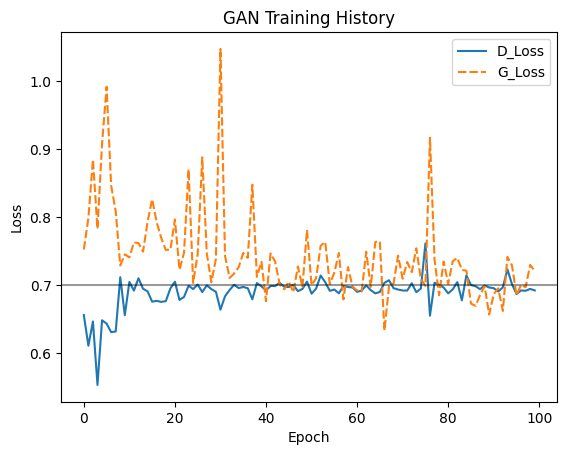

In [321]:
history_gan_df = pd.DataFrame({'D_Loss': history_gan.history['d_loss'], 'G_Loss': history_gan.history['g_loss']})

sns.lineplot(history_gan_df)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training History')
plt.axhline(y = 0.7, c = 'k', alpha = 0.4)
plt.savefig('./Generated_Images/GAN_History.jpg')
plt.show()

In [322]:
gen_images_files = os.listdir(f"{current_wdir}/Generated_Images")
gen_images = {}

for file in gen_images_files:
    # Skip non-image files.
    if '.jpg' not in file:
        continue
    # Separate epoch number, image number, and file extension.
    epoch, _ = file.split('_')
    if '0' not in _:
        continue
    img = Image.open(f"{current_wdir}/Generated_Images/{file}")
    gen_images[epoch] = np.asarray(img)

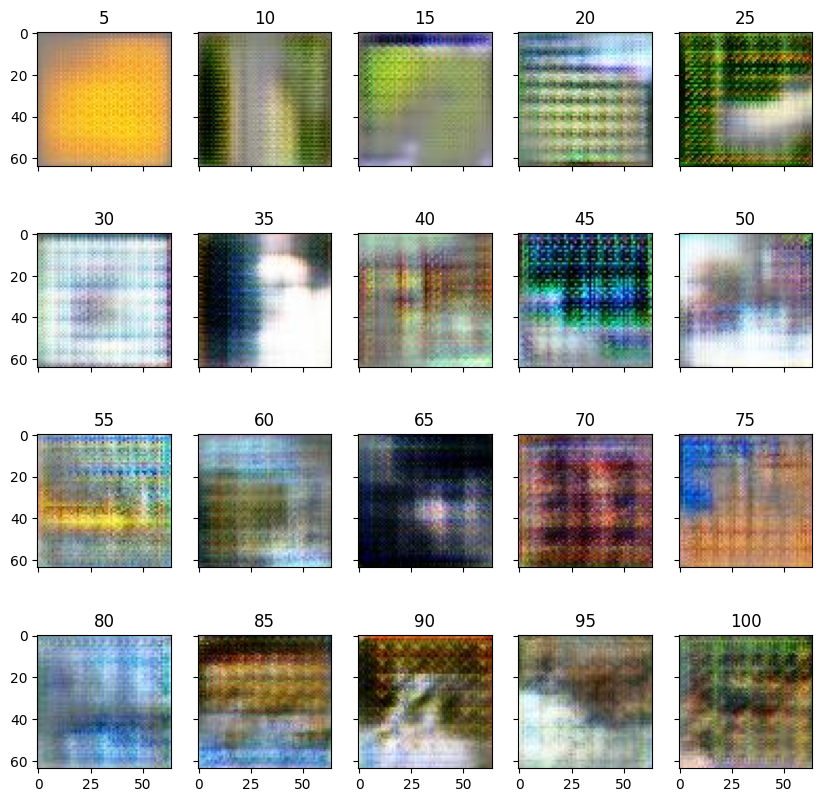

In [334]:
# int((len(range(5, epochs+1, 5)) / 5))
fig, ax = plt.subplots(int((len(range(5, epochs+1, 5)) / 5)), 5, figsize = (10,int(epochs/10)), sharex = True, sharey = True)
for i, idx in enumerate(range(5, epochs+1, 5)):
    ax[i // 5, i % 5].imshow(gen_images[f'{str(idx).zfill(3)}'])
    ax[i // 5, i % 5].set_title(f'{idx}')
plt.savefig('./Generated_Images/5_Epoch_Images.jpg')
plt.show()

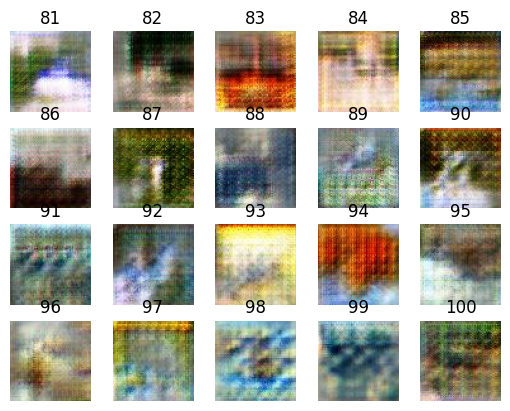

In [324]:
last_gen_img_idx = range(epochs-19, epochs+1, 1)
fig, ax = plt.subplots(4, 5, sharex = True, sharey = True)
for i, idx in enumerate(last_gen_img_idx):
    ax[i // 5, i % 5].imshow(gen_images[f'{str(idx).zfill(3)}'])
    ax[i // 5, i % 5].set_title(f'{idx}')
    ax[i // 5, i % 5].axis('off')
#fig.tight_layout()
plt.savefig('./Generated_Images/Last_20_Images.jpg')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


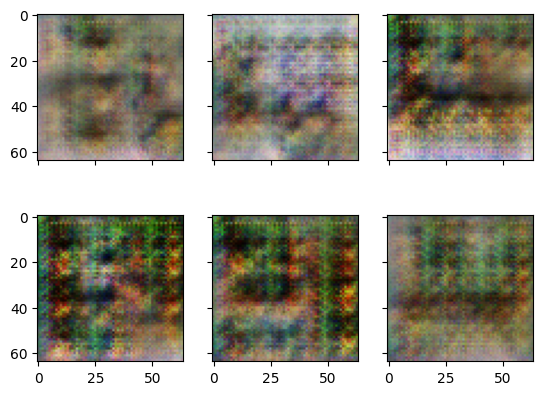

In [325]:
fig, ax = plt.subplots(2, 3, sharex = True, sharey = True)
prediction = generator.predict(np.random.normal(size = (6,latent_dim)))
prediction = ((prediction + 1) * 127.5).astype(np.uint8)
for i in range(6):
    ax[i // 3, i % 3].imshow(prediction[i])
plt.show()

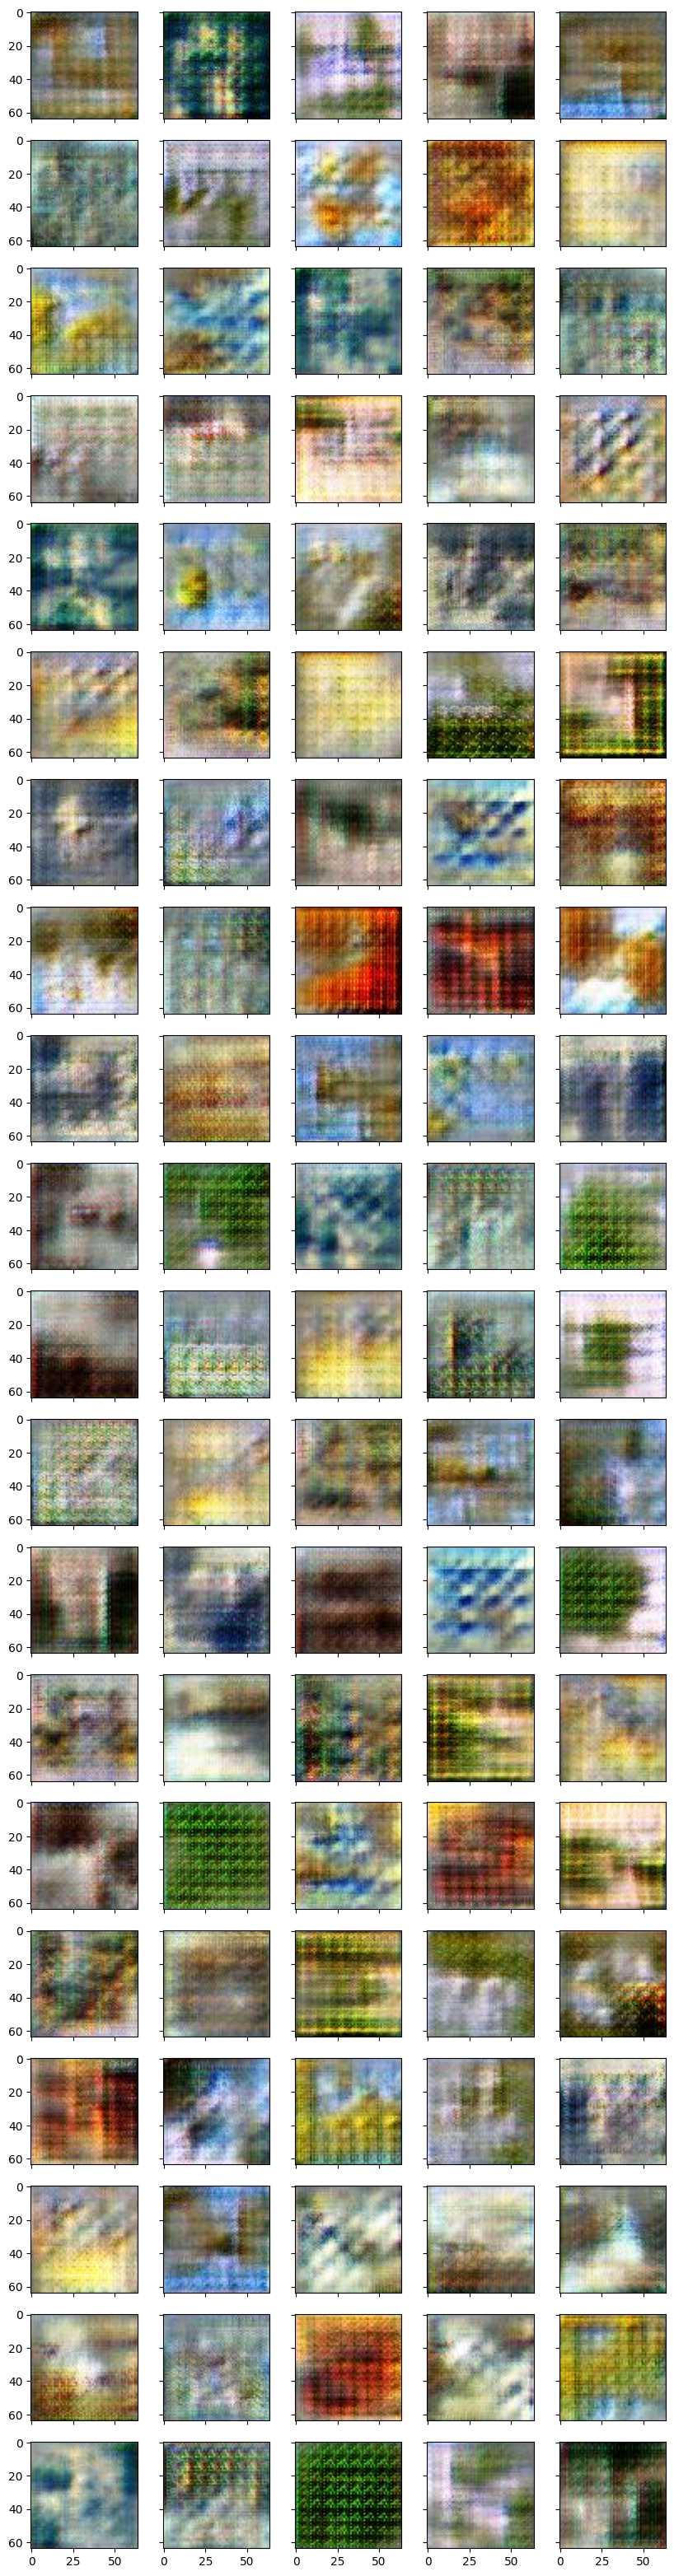

In [326]:
last_20_files = os.listdir(f"{current_wdir}/images")
rand_last_20_images = []

for file in np.random.choice(last_20_files, 100, replace = False):
    # Skip non-image files.
    if '.jpg' not in file:
        continue
    # Separate epoch number, image number, and file extension.
    epoch, num = file.split('_')
    img = Image.open(f"{current_wdir}/images/{file}")
    rand_last_20_images.append(np.asarray(img))

# fig, ax = plt.subplots(20, 5, figsize = (10,40), sharex = True, sharey = True)
fig, ax = plt.subplots(20, 5, figsize = (10,40), sharex = True, sharey = True)
for i, img in enumerate(rand_last_20_images):
    ax[i // 5, i % 5].imshow(img)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


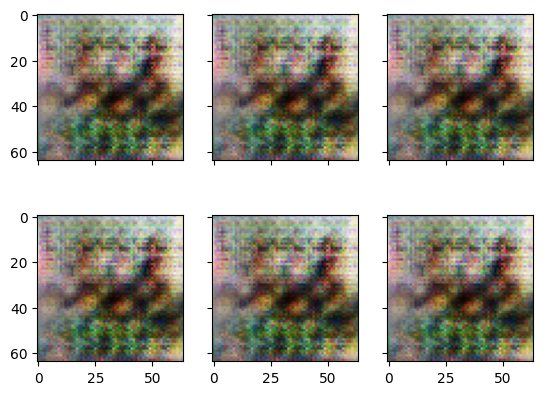

In [327]:
fig, ax = plt.subplots(2, 3, sharex = True, sharey = True)
for i in range(6):
    prediction = generator.predict(np.asarray([[2]*latent_dim]))
    ax[i // 3, i % 3].imshow(((prediction + 1) * 127.5).astype(np.uint8)[0])
plt.show()

To evaluate the test set the .csv files must be submitted to Kaggle. Each model's predictions were saved above and manually submitted. Below you can find a screenshot of all the results.

###### [Back to Table of Contents](#toc)

## 7. Conclusion - Kaggle Submission Test Set <a name="conclusion"></a>

---


### 7.1. Possible Areas for Improvement <a name="improvements"></a>

- 

###### [Back to Table of Contents](#toc)

## Appendix A - Online References: <a name="appendixa"></a>

Resources that helped along the way in no particular order.

- Great tutorial for image generation using GANs https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/
- Starting point for DCGANs https://keras.io/examples/generative/dcgan_overriding_train_step/
- Solution to Mode Collapse! https://arxiv.org/pdf/1810.01365
- Identifying unstable GANs and their failure modes https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

 Exported to HTML via command line using:

- `jupyter nbconvert Adversarial_Painting.ipynb --to html`
- `jupyter nbconvert Adversarial_Painting.ipynb --to html --HTMLExporter.theme=dark`

###### [Back to Table of Contents](#toc)